#### Définissons ici nos folder

In [2]:
import os

INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/sample_images'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

Chargement des coupes pour un patient. Chaque dossier correspond aux différentes coupe pour un patient donné

In [3]:
import dicom
import pylab
import os
import numpy as np



def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    return slices





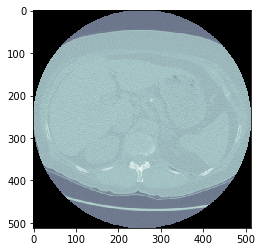

In [4]:
first_patient_path = os.path.join(INPUT_FOLDER,patients[0])
first_patient = load_scan(first_patient_path)
total_images = os.listdir(first_patient_path)


ds=dicom.read_file(os.path.join(first_patient_path,total_images[0]))
pylab.imshow(ds.pixel_array, cmap=pylab.cm.bone)
pylab.show()


In [124]:
print(ds)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.329717298280022717093290522834
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '0acbebb8d463b4b9ca88cf38431aac69'
(0010, 0020) Patient ID                          LO: '0acbebb8d463b4b9ca88cf38431aac69'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.66234994940093060530875882673593880723182397297085825139120
(0020, 000e) Series Instance UID                 UI: 2.25.27985737130106072918310533525688877208529713445697698517643
(0020, 0011) Series Number                       IS: '4'
(0020, 0012) Acquisition Number       

Pour l'instant, notre seul intérêt ce sont les images. Pour un patient donné (ici le premier), on va donc mettre dans un tenseur de taille NOMBRE_SLICE X 512 X 512, toutes les slices

In [5]:
slices = first_patient
image = np.stack([s.pixel_array for s in slices])
print(image.shape)

(128, 512, 512)


Regardons un peu l'allure des valeurs numériques stockées pour un patient

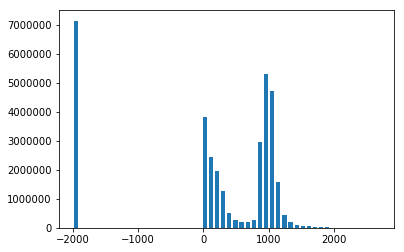

In [6]:
import matplotlib.pyplot as plt

flatten = image.flatten()
hist, bins = np.histogram(flatten, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

On peut alors constater deux choses :

- Les valeurs ne sont pas normées entre 0 et 1, ni entre 0 et 255, mais ont l'air d'aller de 0 à 2 000 (plus en fait si on regarde le maximum). 
- Beaucoup de valeurs sont à - 2000, étrange.

Première démarche : où sont localisées ces valeurs à -2 000 ?

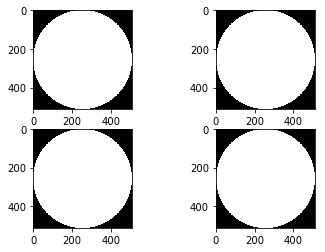

In [74]:
#Le but ici va être de visualiser les -2 000, on va avoir une démarche simple : 
#on crée une copie de notre tenseur d'image, on met un 0 là où y'a des -2000, un 1 sinon
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nrows, ncols = 512,512

bool_image = (image==-2000)
bool_image = (bool_image + 1 - 1)

bool_image_1 = bool_image[0,:,:]
bool_image_2 = bool_image[24,:,:]
bool_image_3 = bool_image[49,:,:]
bool_image_4 = bool_image[124,:,:]


plt.subplot(221)
plt.imshow(bool_image_1,cmap=cm.Greys)
plt.subplot(222)
plt.imshow(bool_image_2,cmap=cm.Greys)
plt.subplot(223)
plt.imshow(bool_image_3,cmap=cm.Greys)
plt.subplot(224)
plt.imshow(bool_image_4,cmap=cm.Greys)

On le voit, elles sont à l'extérieur du cylindre dans lequel est effectuée la CT. 


Nos données sont en Pixel Data. Ce n'est pas l'unité canonique de la CT, celle-ci étant plutôt __HounsfieldUnit (HU)__ . Sur _wikipedia_, il est indiqué que ces valeurs vont entre -1 000 et 3 000, ce qui ne correspond pas à ce que nous avons ici. Cependant, dans les metadata ce trouvent les arguments __Rescale Intercept__ et __Rescale Slope__

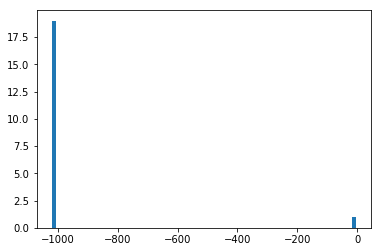

In [100]:
i = 0
Intercept_total = []
patients.sort()
for i in range(len(patients)):
    patient_path = os.path.join(INPUT_FOLDER,patients[i])
    patient = load_scan(patient_path)
    Intercept_total.append(patient[i].RescaleIntercept)

hist, bins = np.histogram(Intercept_total, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()   

A part un cas distinct, le rescale factor vaut -1024. A priori, les valeurs qui correspondent à -2000 sont en fait de l'air, qui à un HU de -1000 après recalibration, en est alors déduit l'opération de transformation suivante :

In [101]:
def PixelData_to_HU(slices):
    #Stack de nos slices dans une tenseur 3D
    image = np.stack([s.pixel_array for s in slices])


    # Les pixels "aberrant (- 2000) sont associés à l'air, qui vaut -1000HU, le rescale valant en général -1024 on fait :
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 24
    
    # Convertion en HU
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        image[slice_number] = slope * image[slice_number]
        image[slice_number] = image[slice_number]
            
    
    return np.array(image)

In [103]:
image_HU = PixelData_to_HU(first_patient)
flatten = image.flatten()
hist, bins = np.histogram(flatten, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

(128, 512, 512)